In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import VECM


# Define file paths
Brazil_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Brazil_GDP.csv'
US_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/USGDP.csv'
Germany_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Germany_GDP.csv'
China_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/China_GDP.csv'
India_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/India_GDP.csv'
Mexico_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Mexico_GDP.csv'


First, pick a stock you would like to forcast from yahoo finance. For the purposes of demonstration we will use quarterly data of the DJIA 

In [9]:
# Read stock data from yfinance 
# ^IXIC Nasdaq
# ^GSPC S&P
# ^DJA Dow
# Brazil Index ^BVSP
# India Index  ^BSESN
# China ^000001.SS
# Germany ^GDAXI
# Mexico ^MXX

ticker = ['^DJA']
start = '1992-12-30'
end = '2023-09-30'
data = yf.download(ticker, start, end, interval='3mo')['Close']
price = data.values.flatten()
T = len(price)

# Create a date range and set frequency
date = pd.date_range(start=start, periods=T, freq='Q-DEC')


# Generating log differences data for analysis
log_price = np.array(np.log(price))
delta_log_price = log_price[1:] - log_price[:-1]

date_diff = date[1:]
stock_data = pd.DataFrame({'price': price}, index=date)

print(len(price))
print(len(date))
stock_data


[*********************100%%**********************]  1 of 1 completed

124
124


,price
1992-12-31,1546.699951
1993-03-31,1613.000000
1993-06-30,1902.800049
1993-09-30,2212.800049
1993-12-31,2585.399902
...,...
2022-09-30,51684.859375
2022-12-31,52758.058594
2023-03-31,52736.261719
2023-06-30,53020.980469


Next, incorporate data on variables that influence the price of your stock. For example if we were investigating an electric car company, we might want to include prices of lithium and other metals used to create cars.
For our purposes we will use the US GDP as the main independent variable influeincing the DJIA

In [10]:
# Define file paths
Brazil_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Brazil_GDP.csv'
US_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/USGDP.csv'
Germany_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Germany_GDP.csv'
China_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/China_GDP.csv'
India_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/India_GDP.csv'
Mexico_gdp = '/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Mexico_GDP.csv'
# Load the Germany GDP CSV file into a DataFrame
df = pd.read_csv(Mexico_gdp)

# Print the length of the second column
print(len(df.iloc[:, 1]))

# Rename the second column to 'GDP'
df.columns.values[1] = 'GDP'

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the modified DataFrame
print(df)

124
           DATE        GDP
0    1993-01-01  3449919.7
1    1993-04-01  3451166.0
2    1993-07-01  3491260.3
3    1993-10-01  3513116.2
4    1994-01-01  3548012.7
..          ...        ...
119  2022-10-01  6140719.8
120  2023-01-01  6175740.9
121  2023-04-01  6233461.4
122  2023-07-01  6279974.8
123  2023-10-01  6286254.8

[124 rows x 2 columns]


After investigating the stock data we see that GDP is collected at the begining of the quarter while the S&P is collected at the end, thus aligning a new dataframe must account for this by taking the first entry out of our GDP data and the last out of our stock data

In [11]:
gdp_df = df #.iloc[1:] 
price_df = stock_data #.iloc[:-1]
gdp_df = gdp_df.drop(columns= 'DATE')


In [12]:
gdp_series = pd.Series(gdp_df['GDP'].values)
price_df['GDP'] = gdp_series.values 
price_df['price_diff'] = price_df['price'].diff()
price_df['GDP_diff'] = price_df['GDP'].diff()
price_df = price_df.iloc[1:] # removing first row due to differencing creating NAN
price_df 

,price,GDP,price_diff,GDP_diff
1993-03-31,1613.000000,3451166.0,66.300049,1246.3
1993-06-30,1902.800049,3491260.3,289.800049,40094.3
1993-09-30,2212.800049,3513116.2,310.000000,21855.9
1993-12-31,2585.399902,3548012.7,372.599854,34896.5
1994-03-31,2477.699951,3628872.6,-107.699951,80859.9
...,...,...,...,...
2022-09-30,51684.859375,6140719.8,6765.640625,41333.7
2022-12-31,52758.058594,6175740.9,1073.199219,35021.1
2023-03-31,52736.261719,6233461.4,-21.796875,57720.5
2023-06-30,53020.980469,6279974.8,284.718750,46513.4


In [13]:
price_df.to_csv('price_data.csv', index=True)  # Set index=False if you don't want to write row indices to the CSV file


Stationarity Test


In [14]:
# ADF test for GDP
#    Run Augmented Dickey-Fuller test on a given series.

#   Parameters:
#   series (pd.Series): Time series data.
#   regression_type (str): Type of regression ('c', 'ct', 'ctt', 'nc') to include in the test.
#                          'c' - Constant only (default)
#                          'ct' - Constant and trend
#                          'ctt' - Constant, linear and quadratic trend
#                          'nc' - No constant, no trend

def perform_adf_test(series, regression_type='ct'):
    """
    Perform an Augmented Dickey-Fuller test on a given time series.

    Parameters:
        series (pd.Series): The time series on which to perform the ADF test.
        regression_type (str): The type of regression ('c' for constant, 'ct' for constant and trend, 'ctt' for constant, and linear and quadratic trend, 'nc' for no constant, no trend).

    Returns:
        None
    """
    result = adfuller(series, regression=regression_type)
    print(f"ADF Statistic for {series.name}: {result[0]}")
    print(f"p-value for {series.name}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[0] < result[4]['5%']:
        print(f"Reject the null hypothesis - the {series.name} series is stationary at the 95% confidence level.")
    else:
        print(f"Fail to reject the null hypothesis - the {series.name} series is not stationary at the 95% confidence level.")


In [15]:
perform_adf_test(price_df['GDP_diff'],regression_type='ct')
perform_adf_test(price_df['price_diff'],regression_type='ct')
perform_adf_test(price_df['price'],regression_type='ct')
perform_adf_test(price_df['GDP'],regression_type='ct')


ADF Statistic for GDP_diff: -9.631926509280893
p-value for GDP_diff: 1.4281042927225128e-14
Critical Values:
	1%: -4.036
	5%: -3.447
	10%: -3.149
Reject the null hypothesis - the GDP_diff series is stationary at the 95% confidence level.
ADF Statistic for price_diff: -11.314815097893899
p-value for price_diff: 5.783190387585664e-18
Critical Values:
	1%: -4.035
	5%: -3.447
	10%: -3.149
Reject the null hypothesis - the price_diff series is stationary at the 95% confidence level.
ADF Statistic for price: -2.665032963914492
p-value for price: 0.25088601477251016
Critical Values:
	1%: -4.035
	5%: -3.447
	10%: -3.149
Fail to reject the null hypothesis - the price series is not stationary at the 95% confidence level.
ADF Statistic for GDP: -3.999206861559667
p-value for GDP: 0.008816547738032967
Critical Values:
	1%: -4.035
	5%: -3.447
	10%: -3.149
Reject the null hypothesis - the GDP series is stationary at the 95% confidence level.


Next we plot the significant lag effects of previous observations on GDP and Stock Price

<Figure size 720x360 with 0 Axes>

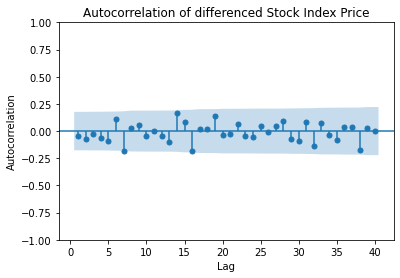

<Figure size 720x360 with 0 Axes>

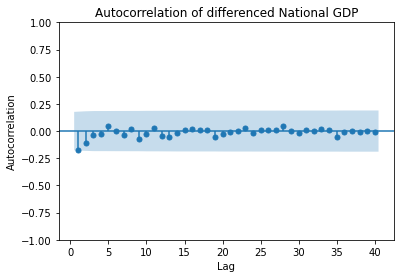

<Figure size 720x360 with 0 Axes>

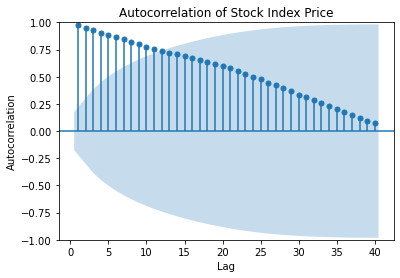

<Figure size 720x360 with 0 Axes>

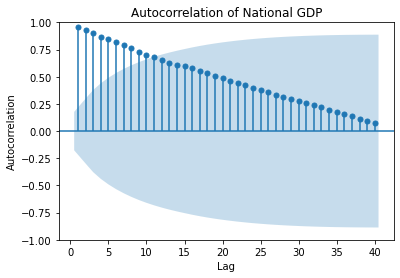

In [42]:
# Plot Correlogram for differenced Stock Index Price
plt.figure(figsize=(10, 5))
plot_acf(price_df['price_diff'], lags=40, zero=False, title='Autocorrelation of differenced Stock Index Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for differenced GDP
plt.figure(figsize=(10, 5))
plot_acf(price_df['GDP_diff'], lags=40, zero=False, title='Autocorrelation of differenced National GDP')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for DJIA Price
plt.figure(figsize=(10, 5))
plot_acf(price_df['price'], lags=40, zero=False, title='Autocorrelation of Stock Index Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
# Plot Correlogram for GDP
plt.figure(figsize=(10, 5))
plot_acf(price_df['GDP'], lags=40, zero=False, title='Autocorrelation of National GDP')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

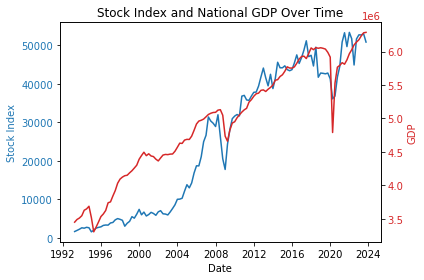

In [56]:
fig, ax1 = plt.subplots()

# Plot the Price data on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index', color=color)
ax1.plot(price_df.index, price_df['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('GDP', color=color)  # we already handled the x-label with ax1
ax2.plot(price_df.index, price_df['GDP'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Stock Index and National GDP Over Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Show the plot
plt.show()


We take first differences to use in prediction models later on

In [45]:
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

# Perform the Johansen cointegration test
data = price_df[['price_diff', 'GDP_diff']]

result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Print the Trace Statistics and Critical Values
print('Trace Statistics:', result.lr1)
print('Critical Values (90%, 95%, 99%):', result.cvt)

# Interpret and print whether cointegration is found
cointegration_found = False  # A flag to keep track of cointegration status
for i, trace_stat in enumerate(result.lr1):
    if trace_stat > result.cvt[i][1]:  # Index 1 is for the 95% confidence level
        cointegration_found = True
        print(f"At the 95% confidence level, we reject the null hypothesis of at most {i} cointegrating relations; indicating cointegration.")
    else:
        print(f"At the 95% confidence level, we fail to reject the null hypothesis of at most {i} cointegrating relations; no cointegration indicated.")

# Print overall result based on tests
if cointegration_found:
    print("The series exhibit a long-run cointegrating relationship.")
else:
    print("No long-run cointegrating relationship is evident among the series.")


Trace Statistics: [135.10594653  56.51085004]
Critical Values (90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
At the 95% confidence level, we reject the null hypothesis of at most 0 cointegrating relations; indicating cointegration.
At the 95% confidence level, we reject the null hypothesis of at most 1 cointegrating relations; indicating cointegration.
The series exhibit a long-run cointegrating relationship.


This means there are at least two independent long-term equilibrium relationships tying these variables together. Each cointegrating relation can be seen as a different equilibrium condition that the variables adhere to over time.

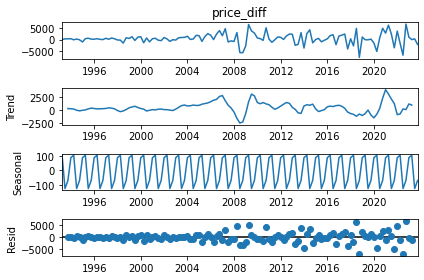

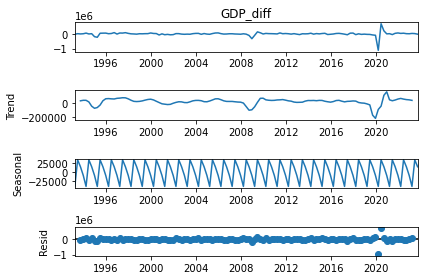

In [46]:

# Decompose stock market data
result_price = seasonal_decompose(data['price_diff'], model='additive', period=4)  # Quarterly data, adjust 'period' as needed
result_price.plot()
plt.show()

# Decompose GDP data
result_gdp = seasonal_decompose(data['GDP_diff'], model='additive', period=4)  # Quarterly data, adjust 'period' as needed
result_gdp.plot()
plt.show()


/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_50955/1795508091.py:7: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, np.abs(fft_series), 'b', markerfmt=" ", basefmt="-b")


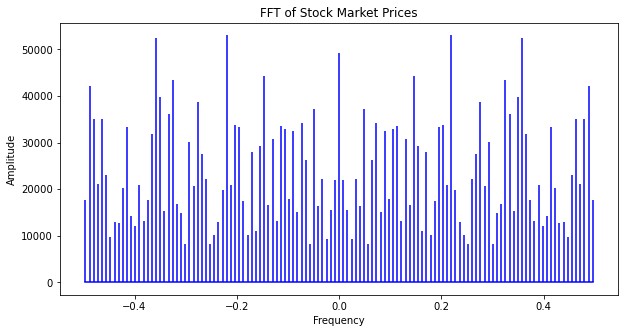

/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_50955/1795508091.py:7: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, np.abs(fft_series), 'b', markerfmt=" ", basefmt="-b")


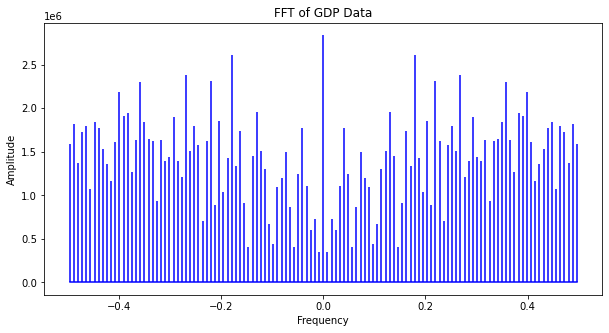

In [47]:

def plot_fft(series, title):
    # Compute the fast Fourier Transform
    n = len(series)
    freq = np.fft.fftfreq(n)
    fft_series = np.fft.fft(series)
    plt.figure(figsize=(10, 5))
    plt.stem(freq, np.abs(fft_series), 'b', markerfmt=" ", basefmt="-b")
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()

plot_fft(price_df['price_diff'], 'FFT of Stock Market Prices')
plot_fft(price_df['GDP_diff'], 'FFT of GDP Data')


We see potential evidence of seasonality with stock price, while we are less sure about gdp. fluctuations outside the mean are small

Central Peak:
Low-Frequency Dominance: This central peak at or near zero frequency suggests that the primary component of your time series is a trend. This means the long-term direction of the stock prices is a significant feature of the data.
Side Peaks:
Seasonal or Cyclical Effects: The presence of additional peaks at regular intervals could indicate seasonal effects, assuming the data's time frame captures full seasonal cycles (e.g., quarterly or annually). The distance between these peaks can give an indication of the periodicity of the seasonal or cyclical components.

In [48]:
from statsmodels.tsa.vector_ar.vecm import select_order

# Fit the model
# Determine the optimal lag order
lag_order = select_order(data=data, maxlags=10, deterministic="ci")
print(lag_order.summary())


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        39.32      39.51*   1.190e+17      39.40*
1        39.33       39.63   1.210e+17       39.45
2        39.38       39.77   1.273e+17       39.54
3        39.43       39.91   1.326e+17       39.62
4        39.45       40.04   1.364e+17       39.69
5        39.39       40.07   1.280e+17       39.66
6        39.28       40.05   1.146e+17       39.59
7        39.26       40.14   1.131e+17       39.62
8       39.23*       40.20  1.094e+17*       39.62
9        39.25       40.32   1.123e+17       39.68
10       39.27       40.44   1.155e+17       39.75
--------------------------------------------------


In [49]:
rank_test = select_coint_rank(data, 0, 3, method="trace",
                              signif=0.05)
rank_test.summary()


r_0,r_1,test statistic,critical value
0,2,79.20,15.49
1,2,35.21,3.841


VECM Model: setting up a VECM with the specified lag order and cointegration rank, examining both short-term dynamics and long-term equilibrium relationships in the data. 


In [50]:
model = VECM(data, deterministic="ci", seasons=0, k_ar_diff = 8, coint_rank= 1)

In [51]:
vecm_res = model.fit()
vecm_res.summary()



,coef,std err,z,P>|z|,[0.025,0.975]
L1.price_diff,-0.9166,0.278,-3.301,0.001,-1.461,-0.372
L1.GDP_diff,0.0037,0.008,0.470,0.638,-0.012,0.019
L2.price_diff,-0.8056,0.273,-2.954,0.003,-1.340,-0.271
L2.GDP_diff,0.0012,0.007,0.159,0.874,-0.013,0.015
L3.price_diff,-0.7655,0.263,-2.912,0.004,-1.281,-0.250
L3.GDP_diff,0.0004,0.006,0.059,0.953,-0.012,0.013
L4.price_diff,-0.5566,0.244,-2.277,0.023,-1.036,-0.077
L4.GDP_diff,-0.0038,0.006,-0.676,0.499,-0.015,0.007
L5.price_diff,-0.4516,0.225,-2.009,0.045,-0.892,-0.011
L5.GDP_diff,-0.0066,0.005,-1.387,0.166,-0.016,0.003


array([[-3.96326257e+02, -7.32200497e+04],
       [ 1.92067784e+03,  2.58888520e+05],
       [-7.09415232e+02, -1.79233859e+05],
       [ 1.70130509e+02,  4.12427830e+04],
       [ 1.19684025e+03,  5.29331423e+04],
       [-5.58728586e+02, -3.95950216e+04],
       [ 3.49702820e+02,  7.56237537e+04],
       [ 1.52146539e+03,  2.40342919e+04]])

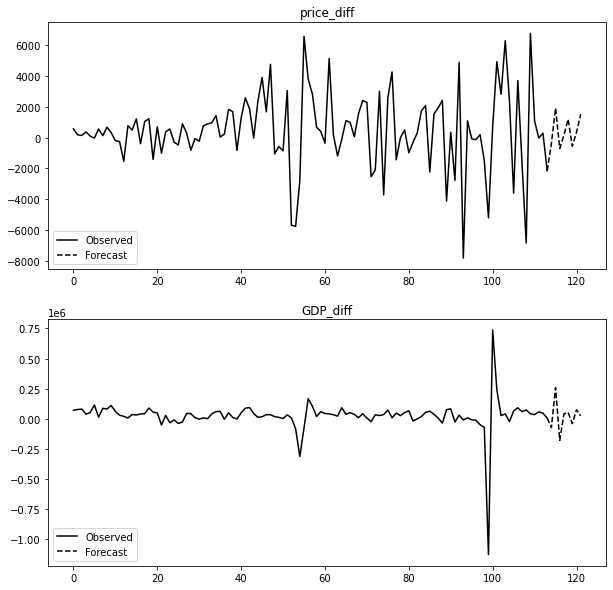

In [52]:
vecm_res.plot_forecast(steps=8, plot_conf_int=False)
df = vecm_res.predict(steps=8)
df

Impulse Response Function (IRF): While VECMs aren't typically used for impulse response analysis in the same way VAR models are, we've included an IRF generation. This helps in analyzing how a shock to one variable affects others over time within the VECM framework.



Takning the differenced forcasts and using them to find predicted GDP and stock price levels

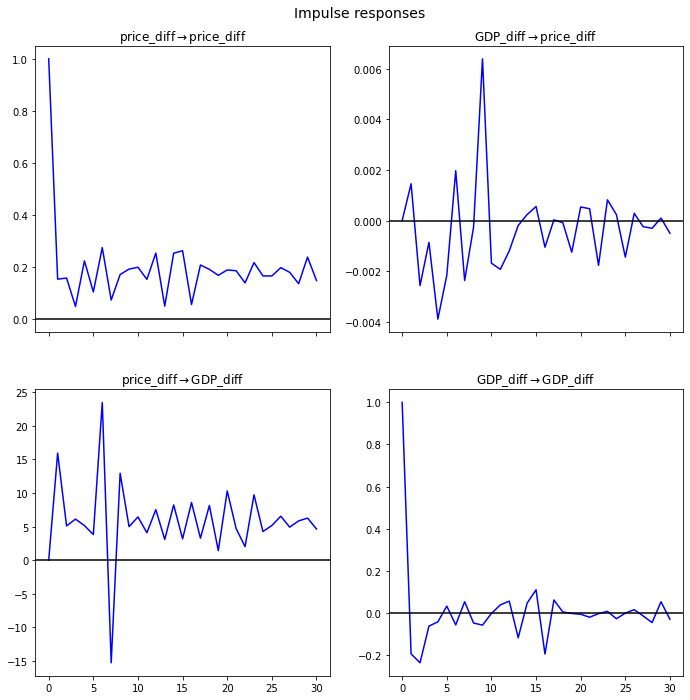

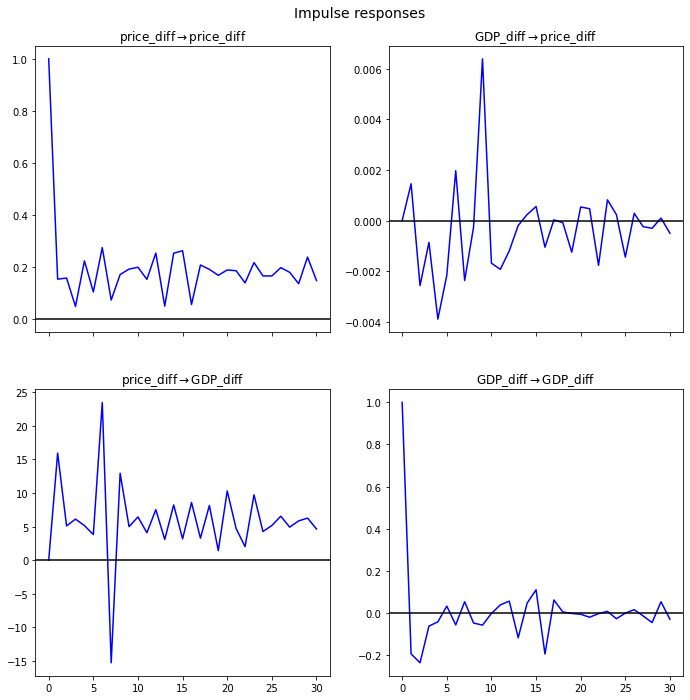

In [53]:
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

Forecast Level Calculation:

add the forecasted differences back to the last observed level, making the output interpretable in the original data's context.

In [57]:
from dateutil.relativedelta import relativedelta

# Last observed level data
last_gdp = price_df['GDP'].iloc[-1]
last_price = price_df['price'].iloc[-1]

# Forecast of differenced data
forecast_diff = df

# Add differences to the last observed level data
forecast_gdp = last_gdp + np.cumsum(forecast_diff[:, 1])
forecast_price = last_price + np.cumsum(forecast_diff[:, 0])


# Get the last date in price_df.index
last_date = price_df.index[-1]

# Add one quarter to the last date
forecast_date = last_date + relativedelta(months=+3)

# Create forecast_dates using pd.date_range
forecast_dates = pd.date_range(start=forecast_date, periods=len(forecast_diff), freq='Q')
forecast_df = pd.DataFrame({
    'price': forecast_price,
    'GDP': forecast_gdp,
    'price_diff': forecast_diff[:, 1],
    'GDP_diff': forecast_diff[:, 0]
}, index=forecast_dates)

forecast_df

,price,GDP,price_diff,GDP_diff
2023-12-31,50478.654212,6.213035e+06,-73220.049714,-396.326257
2024-03-31,52399.332048,6.471923e+06,258888.519952,1920.677836
2024-06-30,51689.916816,6.292689e+06,-179233.859198,-709.415232
2024-09-30,51860.047325,6.333932e+06,41242.783010,170.130509
2024-12-31,53056.887575,6.386865e+06,52933.142266,1196.840250
2025-03-31,52498.158989,6.347270e+06,-39595.021577,-558.728586
2025-06-30,52847.861809,6.422894e+06,75623.753724,349.702820
2025-09-30,54369.327195,6.446928e+06,24034.291938,1521.465386


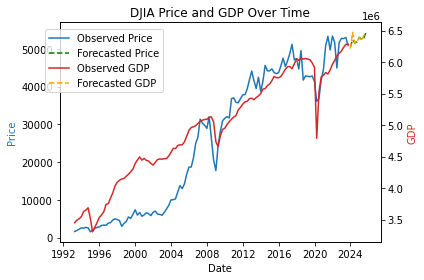

In [58]:
import matplotlib.pyplot as plt

# Plotting observed Price data
fig, ax1 = plt.subplots()

color_observed = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color_observed)
ax1.plot(price_df.index, price_df['price'], color=color_observed, label='Observed Price')

# Plotting forecasted Price data
ax1.plot(forecast_df.index, forecast_df['price'], linestyle='--', color='green', label='Forecasted Price')

# Create a second y-axis for the GDP data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_gdp = 'tab:red'
ax2.set_ylabel('GDP', color=color_gdp)
ax2.plot(price_df.index, price_df['GDP'], color=color_gdp, label='Observed GDP')
ax2.plot(forecast_df.index, forecast_df['GDP'], linestyle='--', color='orange', label='Forecasted GDP')

# Title and legend
plt.title('DJIA Price and GDP Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()


merge observed values with prediction

In [59]:
merged_df = pd.concat([price_df, forecast_df])
T = len(merged_df)
T
price = merged_df['price']

In [60]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1
date = pd.date_range(start=start, periods=T, freq='Q-DEC')

def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        # Placeholder for SADF/GSADF calculation: this should ideally be replaced
        # with a function that calculates the SADF/GSADF statistic.
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


Critical values at 90%, 95%, 99%: [-0.03333333  0.58114231  1.3549764 ]


In [61]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(price[:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)

The SADF statistic: 5.429542156834656


In [62]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(price[r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)

The GSADF statistic: 5.897451308915958
The critical values: [-0.03333333  0.58114231  1.3549764 ]


In [63]:
print(len(dateS), len(bsadfs), len(badfs)) 


110 111 111


In [64]:
# Removing excess values not in the date range
badfs_plt = badfs[:-1]
bsadfs_plt = bsadfs[:-1]

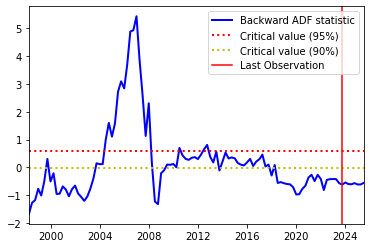

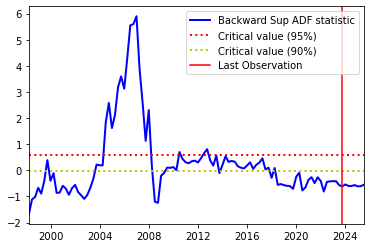

In [65]:
# Plot the backward ADF statistics
plt.figure(1)
plt.plot(dateS, badfs_plt, '-b', linewidth=2)
plt.plot(dateS, [critical_values[1]] * len(dateS), ':r', linewidth=2)
plt.plot(dateS, [critical_values[0]] * len(dateS), ':y', linewidth=2)
plt.axvline(last_date, color='r', linestyle='-')  # Add vertical line at last_date
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward ADF statistic', 'Critical value (95%)', 'Critical value (90%)','Last Observation'])

# Plot the Generalized SADF statistics
plt.figure(2)
plt.plot(dateS, bsadfs_plt, '-b', linewidth=2)
plt.plot(dateS, [critical_values[1]] * len(dateS), ':r', linewidth=2)
plt.plot(dateS, [critical_values[0]] * len(dateS), ':y', linewidth=2)
plt.axvline(last_date, color='r', linestyle='-')  # Add vertical line at last_date
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward Sup ADF statistic', 'Critical value (95%)','Critical value (90%)', 'Last Observation'])

plt.show()


If we only use the long run relationship between GDP and the DJIA, our forcast will always lead to the continued growth of a bubble. 
We can see the likelyhood of a bubble follows a positive trend, interupted by well known financial crisis (dot com bubble, 2008, covid era). 